## 2. Lake model: Exploring the behavior of a decision-making system

Explore the lake problem, connect it to the workbench, investigate system behavior, analyze trade-offs, and learn about parallelization.

See also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

### Overview of this notebook
- Learn about the Lake Problem, a decision-making example about pollution management
  - Connect the Python implementation of the lake model to the EMA workbench
  - Define and explore uncertainties and decision levers in the model
- Investigate the behavior of the system under various scenarios and policies
  - Visualize and analyze trade-offs between outcomes
- Experiment with parallelization techniques to improve computational efficiency

### The Lake model
The exploratory modeling workbench includes an [examples folder](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples). This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench.

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. <u> The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. If the pollution in the lake passes a threshold, it will suffer irreversible eutrophication (nutrient overenrichment). </u>

#### Model
This can be modeled as a system of ordinary differential equations (ODEs) as follows:

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where
 - $X_t$ is the pollution at time $t$
 - $a_t$ is the rate of anthropogenic pollution at time $t$
 - $b$ is the lake’s natural removal rate
 - $q$ is the lake's natural recycling rate
 - $\epsilon_t$ is the rate of natural pollution at time $t$.

The rate of anthropogenic pollution $a_t$ is the <u> decision variable </u> and is somewhere between 0 and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$.


#### Outcomes
There are four outcomes of interest.
 1. The first is the average concentration of phosphor in the lake.

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

   where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time.

 2. The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

   where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.

  3. The third objective is related to the year-over-year change in the anthropogenic pollution rate.

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

   where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years when the absolute value of the change in anthropogenic pollution is larger then $\tau$.

 4. The fourth objective is the fraction of years when the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

   where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

#### Uncertainty
The lake problem is characterized by both stochastic uncertainty and deep uncertainty.
 - The **stochastic uncertainty** arises from the <u> natural inflow </u>. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replications is taken.
 - **Deep uncertainty** is presented by uncertainty about the mean $\mu$ and standard deviation $\sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values.

### Assignment 2.1
_If you at any moment get stuck on this assignment, the [General Introduction](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/general-introduction.html) of the EMAworkbench is a good source of inspiration._

1. Given the Python implementation of the lake problem in [`lakemodel_function.py`](lakemodel_function.py), adapt this code and connect it to the workbench.

For the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that <u> for each year a release decision is made </u>. The release is between 0 and 0.1. Carefully look at line 24 in `lakemodel_function.py` to identify the name to use for each lever.

In [6]:
from lakemodel_function import lake_problem
# import ema_workbench
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model

# Instantiate the model
model = Model('lakeproblem', function=lake_problem)

# Specify uncertainties
model.uncertainties = [
    RealParameter('mean', 0.01, 0.05),  # mean of the lognormal distribution
    RealParameter('stdev', 0.001, 0.005),  # standard deviation of the lognormal distribution
    RealParameter('b', 0.1, 0.45),  # natural removal rate of the lake
    RealParameter('q', 2, 4.5),  # natural recycling rate of the lake
    RealParameter('delta', 0.93, 0.99)  # discount rate
]

# Set levers, one for each time step
model.levers = [RealParameter(f'l{i}', 0, 0.1) for i in range(100)]

# Specify outcomes; max_P, utility, inertia, reliability
model.outcomes = [
    ScalarOutcome('max_P'),
    ScalarOutcome('utility'),
    ScalarOutcome('inertia'),
    ScalarOutcome('reliability')
]


### Assignment 2.2
2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


#### Perform experiments for 1000 scenarios w/o policy

In [33]:
from ema_workbench import perform_experiments, MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=0)

[MainProcess/INFO] pool started with 16 workers
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 2346.66it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [34]:
print(experiments.shape)
print(list(outcomes.keys()))

(1000, 8)
['max_P', 'utility', 'inertia', 'reliability']


In [32]:
outcomes.keys()

dict_keys(['max_P', 'utility', 'inertia', 'reliability'])

In [36]:
experiments

,b,delta,mean,q,stdev,scenario,policy,model
0,0.195344,0.985883,0.033650,2.745239,0.004195,4000,None,lakeproblem
1,0.341343,0.969953,0.018610,3.389234,0.002474,4001,None,lakeproblem
2,0.286459,0.935766,0.046620,4.028652,0.001668,4002,None,lakeproblem
3,0.324042,0.953055,0.019061,3.174826,0.001077,4003,None,lakeproblem
4,0.398440,0.952310,0.036691,3.874925,0.002528,4004,None,lakeproblem
...,...,...,...,...,...,...,...,...
995,0.143186,0.978940,0.039358,3.165244,0.001441,4995,None,lakeproblem
996,0.350301,0.937749,0.034892,2.805246,0.002238,4996,None,lakeproblem
997,0.387398,0.947070,0.012655,3.900867,0.002191,4997,None,lakeproblem
998,0.406737,0.971216,0.030923,3.082634,0.002020,4998,None,lakeproblem


In [53]:
# Create a combined dataframe of the outcomes and the experiments

# Copy the experiments dataframe
data = experiments.copy()

# Join the outcomes to the experiments dataframe
for key in outcomes.keys():
    data[key] = outcomes[key]

data

,b,delta,mean,q,stdev,scenario,policy,model,max_P,utility,inertia,reliability
0,0.195344,0.985883,0.033650,2.745239,0.004195,4000,None,lakeproblem,5.237895,0.0,0.0,0.3565
1,0.341343,0.969953,0.018610,3.389234,0.002474,4001,None,lakeproblem,0.055406,0.0,0.0,1.0000
2,0.286459,0.935766,0.046620,4.028652,0.001668,4002,None,lakeproblem,0.165686,0.0,0.0,1.0000
3,0.324042,0.953055,0.019061,3.174826,0.001077,4003,None,lakeproblem,0.059617,0.0,0.0,1.0000
4,0.398440,0.952310,0.036691,3.874925,0.002528,4004,None,lakeproblem,0.092894,0.0,0.0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.143186,0.978940,0.039358,3.165244,0.001441,4995,None,lakeproblem,7.245694,0.0,0.0,0.1933
996,0.350301,0.937749,0.034892,2.805246,0.002238,4996,None,lakeproblem,0.105658,0.0,0.0,1.0000
997,0.387398,0.947070,0.012655,3.900867,0.002191,4997,None,lakeproblem,0.033348,0.0,0.0,1.0000
998,0.406737,0.971216,0.030923,3.082634,0.002020,4998,None,lakeproblem,0.077352,0.0,0.0,1.0000


<span style="color:red">

#### Plot distribution of outcomes

The results below show that the outcomes clustered around certain values, meaning that the uncertainties do not affect the outcomes that much.

</span>

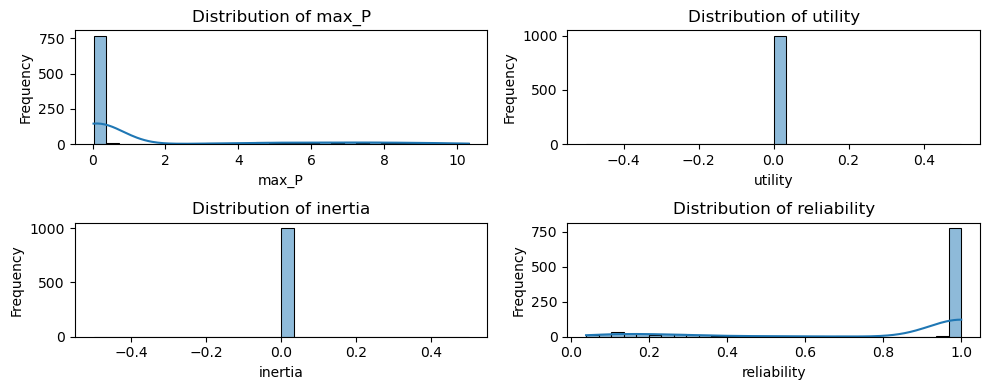

In [58]:
import seaborn as sns

import matplotlib.pyplot as plt

# List of outcomes to plot
outcomes_list = outcomes.keys()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 4))

# Plot each outcome
for ax, outcome in zip(axes.flatten(), outcomes_list):
    sns.histplot(data[outcome], kde=True, ax=ax, bins=30)
    ax.set_title(f'Distribution of {outcome}')
    ax.set_xlabel(outcome)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<span style="color:red">

#### Scatter plot to show the relationship between one uncertainty and one outcome at a time.

* The results below show that varying values of uncertainties doesn't affect **utility** and **inertia**.
* **max_P** and **reliability** are affected by the uncertainties in some scenarios.
* In some scenarios, **max_P** are negatively affected by b.

</span>

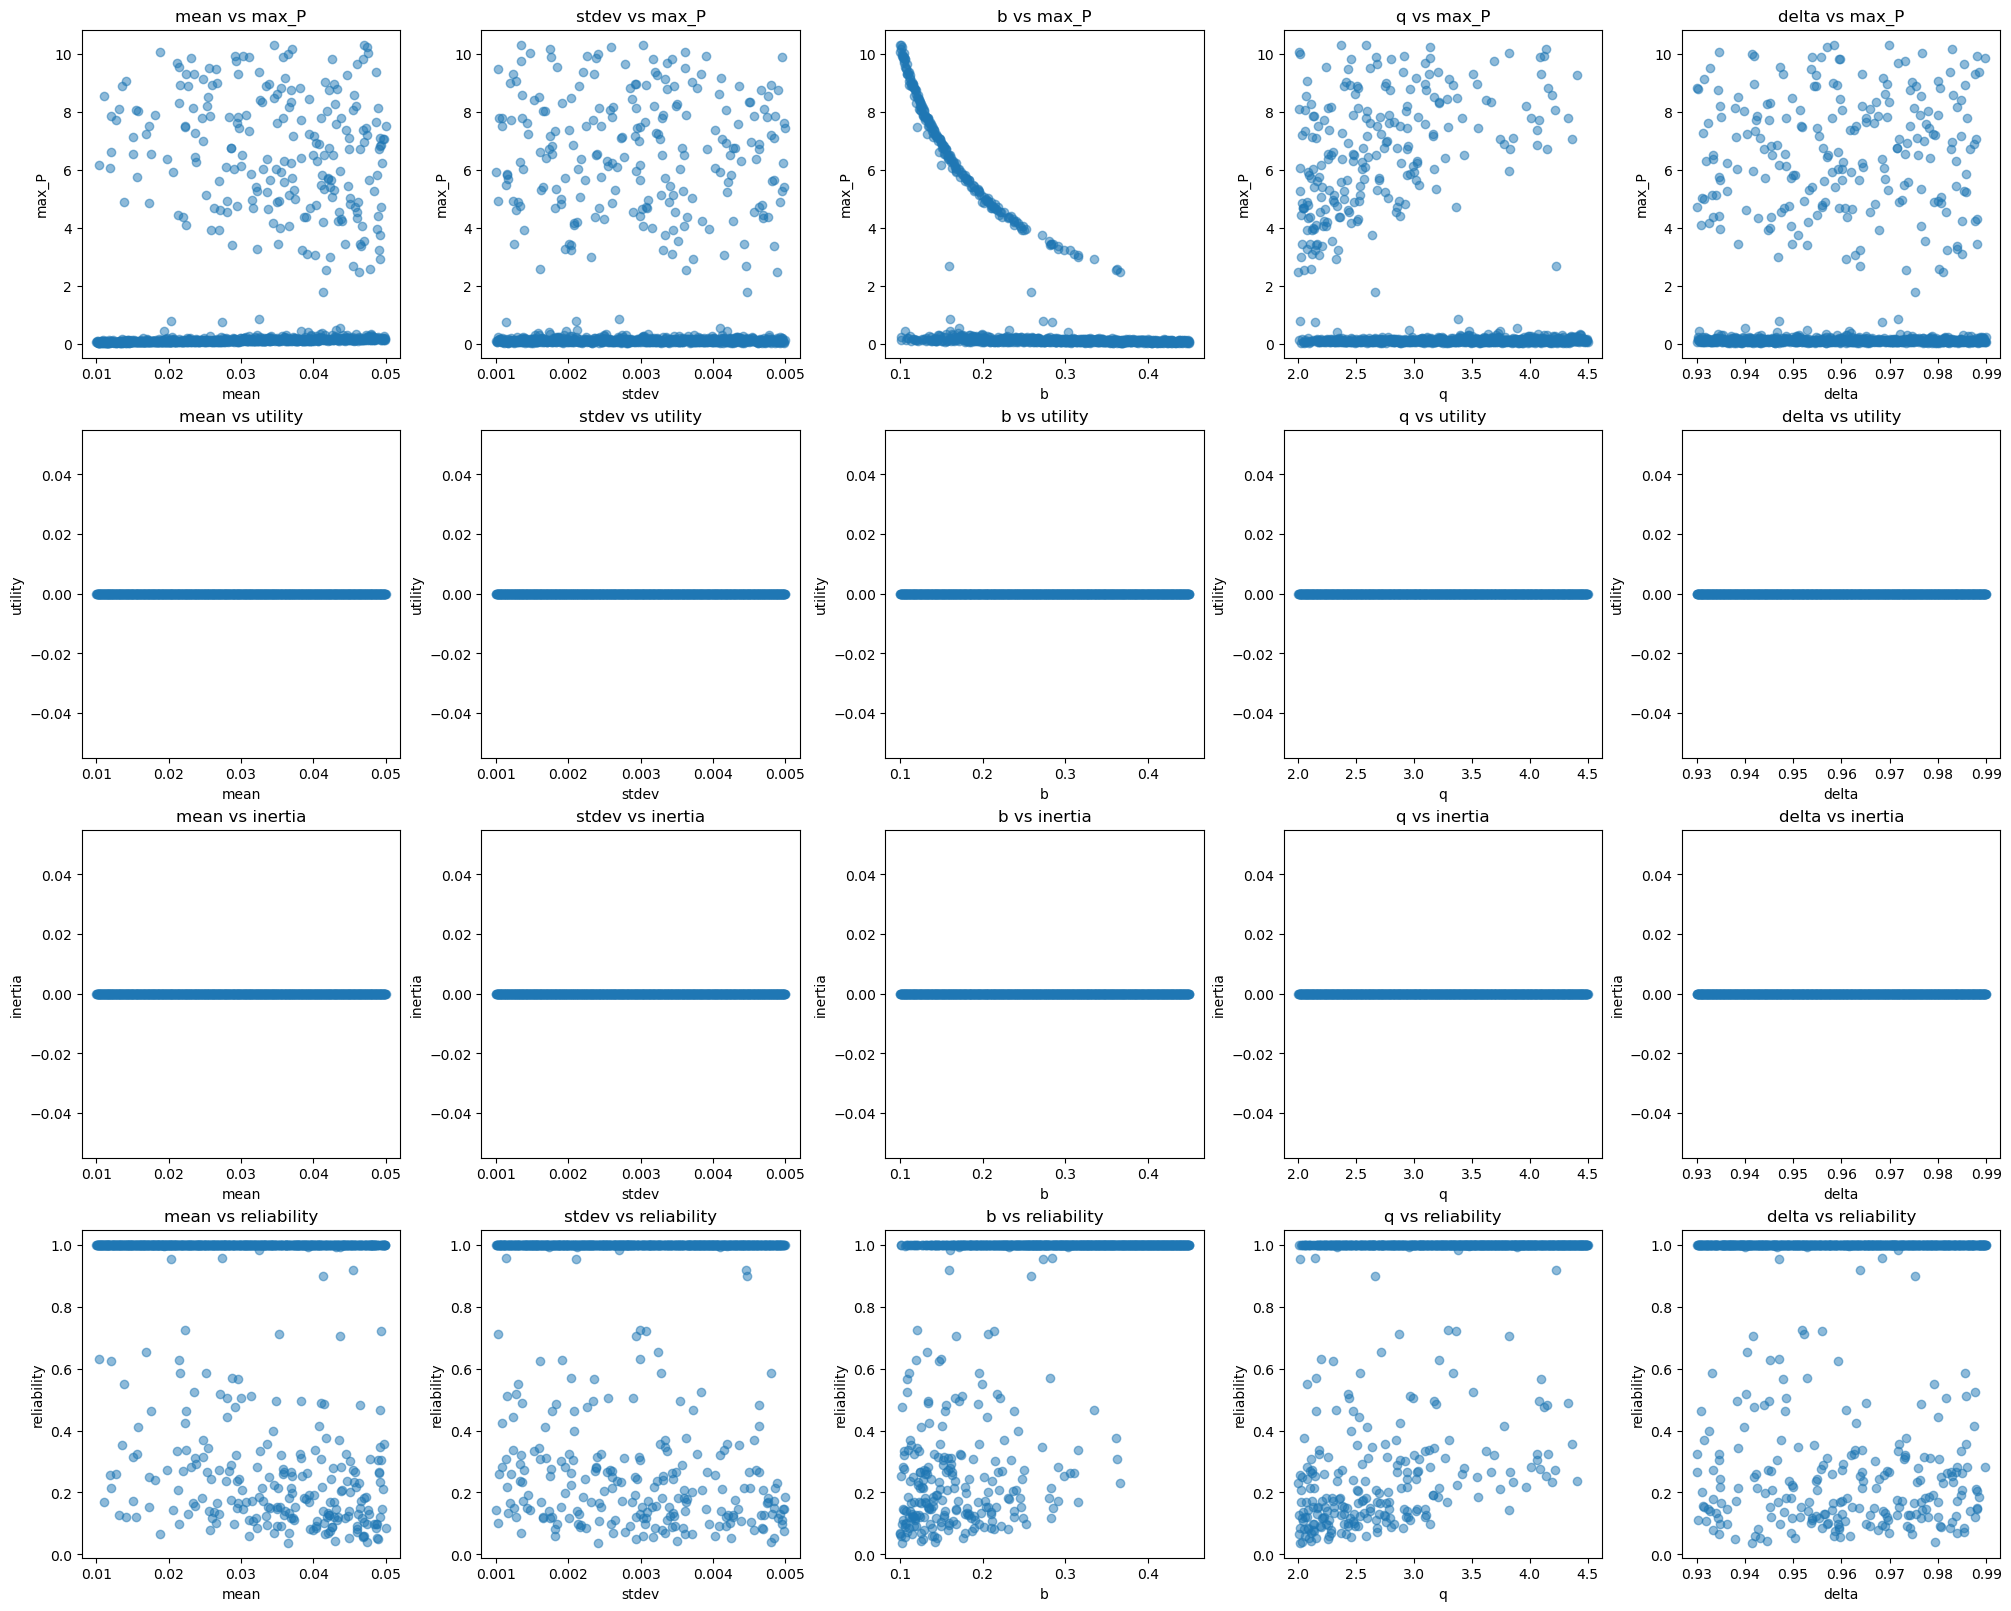

In [61]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(20, 16), constrained_layout=True)

outcomes_list = outcomes.keys()
uncertainties_list = ['mean', 'stdev', 'b', 'q', 'delta']

for i, outcome in enumerate(outcomes_list):
    for j, uncertainty in enumerate(uncertainties_list):
        ax = axes[i, j]
        ax.scatter(experiments[uncertainty], outcomes[outcome], alpha=0.5)
        ax.set_xlabel(uncertainty)
        ax.set_ylabel(outcome)
        ax.set_title(f'{uncertainty} vs {outcome}')

plt.show()

<span style="color:red">

#### Correlation heatmap to show the strength of relationships among uncertainties


</span>

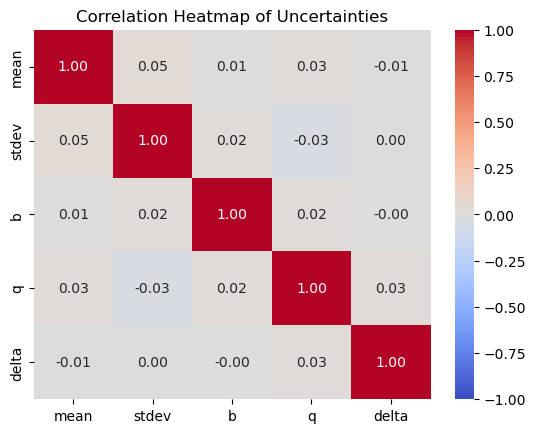

In [65]:
import seaborn as sns
import pandas as pd
import seaborn as sns
import numpy as np

# Select only uncertainties for correlation and plotting
uncertainties_data = data[['mean', 'stdev', 'b', 'q', 'delta']]

# Compute correlation matrix for uncertainties
corr_matrix_uncertainties = uncertainties_data.corr()

# Plot heatmap for uncertainties
sns.heatmap(corr_matrix_uncertainties, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Uncertainties')
plt.show()


<span style="color:red">

#### Correlation heatmap to show the strength of relationships among outcomes
</span>

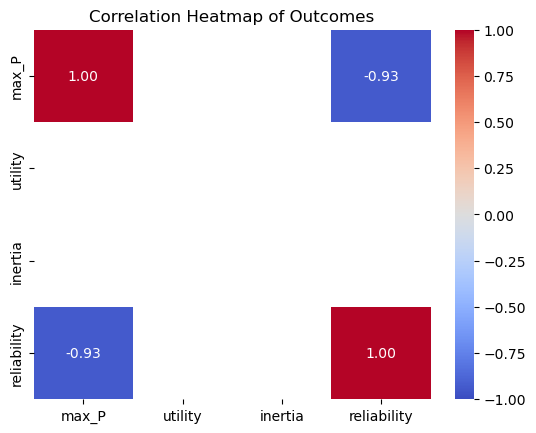

In [66]:
# Select only outcomes for correlation and plotting
outcomes_data = data[['max_P', 'utility', 'inertia', 'reliability']]

# Compute correlation matrix for outcomes
corr_matrix_outcomes = outcomes_data.corr()

# Plot heatmap for outcomes
sns.heatmap(corr_matrix_outcomes, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Outcomes')
plt.show()

<span style="color:red">

#### Correlation heatmap to show the strength of relationships between uncertainties and outcomes
</span>

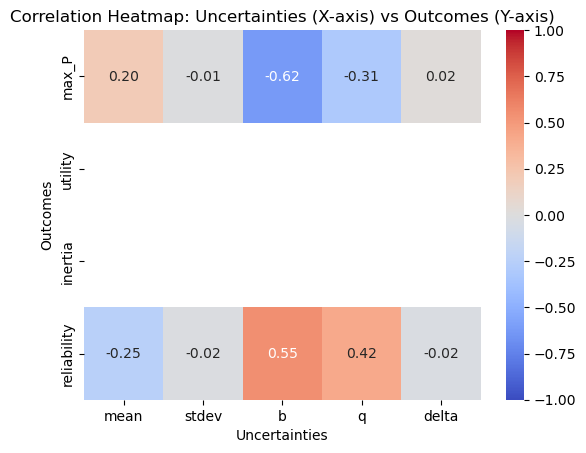

In [72]:
# Compute the combined correlation matrix
numeric_data = data[['mean', 'stdev', 'b', 'q', 'delta', 'max_P', 'utility', 'inertia', 'reliability']]
corr_matrix_combined = numeric_data.corr()

# Transpose the correlation matrix for proper orientation
corr_matrix_transposed = corr_matrix_combined.loc[['max_P', 'utility', 'inertia', 'reliability'], ['mean', 'stdev', 'b', 'q', 'delta']]

# Plot heatmap with uncertainties on the x-axis and outcomes on the y-axis
sns.heatmap(corr_matrix_transposed, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Uncertainties (X-axis) vs Outcomes (Y-axis)')
plt.xlabel('Uncertainties')
plt.ylabel('Outcomes')
plt.show()


In [76]:
outcomes['max_P'].shape

(1000,)

<span style="color:red">

Note that for the lake model, 1 value of an outcome is for 1 scenario
</span>

<span style="color:red">

**can you visually identify the uncertainties that drive system behavior?**
* Mean, b, and q drive reliability and max_P.



</span>

### Assignment 2.3

3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each? Adapt your code from above and sue the `MultiProcessingingEvaluator`. Use the `time` or `timeit` library to check how much faster the computation for 1000 scenarios completes.

#### A note on parallelization in Jupyter notebooks
Using multiprocessing within a Jupyter notebook is tricky. On Linux it will work in general just fine. On a Mac it depends on the version of macOS and the version of Python. If you are on the latest version of macOS in combination with Python 3.8, it might work but no guarantees. On older versions of Python it should work fine. On Windows it is always a problem.

The underlying explanation is quite technical. It has to do with how your operating system creates the additional python processes. On Windows, and the latest version of macOS in combination with Python 3.8. A completely new Python process is spawned. This new process does **not** inherit what is defined in memory of the parent process. The new child process will try to replicate what is in memory of the parent process by executing many of the import statements that have also been executed within the python process. Thus, if you define a model in the main process, it is not guaranteed to be known in the child processes. This is in particular true if you define the model within a jupyter notebook. Then the child processes will **never** know this function. Within jupyter notebooks, therefore, the best practice is to define your model within a `.py` file and import this `.py` file into the notebook. Now, each of the child processes will also execute this import statement and thus know the function.


#### Conclusion
...